In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import sobel
import pandas as pd
from skimage.transform import radon, iradon
from skimage.restoration import denoise_tv_chambolle

# 데이터 불러오기

In [2]:
CT_data = np.load('sinogram.npy')

In [3]:
print("shape", CT_data.shape)
print("CT_data", CT_data)

shape (512, 180)
CT_data [[1337.3376203  1345.08196039 1276.24001283 ... 2986.91175221
  2377.39208315 1442.        ]
 [2999.80624961 2296.19085994 2247.89839002 ... 6005.94918077
  5724.91567885 5308.        ]
 [3894.02907581 3934.91020262 3274.06511728 ... 7601.1985315
  7493.64852201 7419.        ]
 ...
 [6857.71795246 6214.95208569 4801.49051416 ... 4071.1445411
  3976.30591915 3902.        ]
 [4133.76512458 2720.32326348 2148.39654977 ... 3094.93623829
  3372.68906878 3617.        ]
 [1343.11731139 1145.70028692  949.8474563  ... 2033.47634283
  1698.67456108 1205.        ]]


# 데이터 확인하기

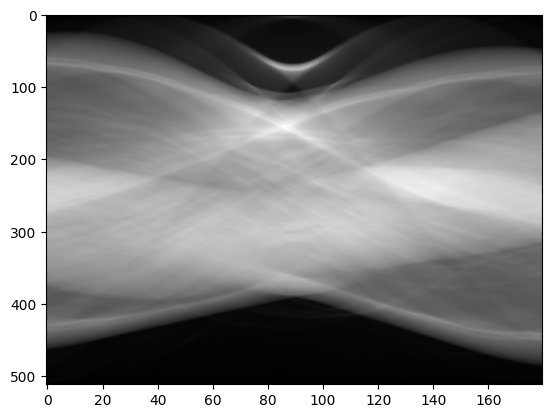

In [4]:
plt.imshow(CT_data, cmap='gray', aspect='auto')

In [5]:
len(CT_data[0])

180

### Every column in the sinogram corresponds to the 1D projection using one angle.

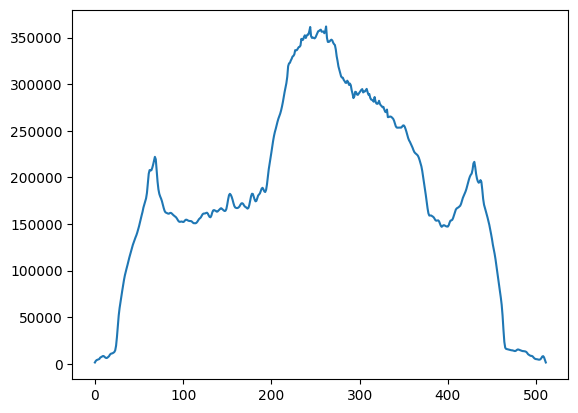

In [6]:
projection_one_dgree = []
for i in range(CT_data.shape[0]):
    projection_one_dgree.append(CT_data[i][0]) # 같은 열끼리 같은 theta
plt.plot(projection_one_dgree)

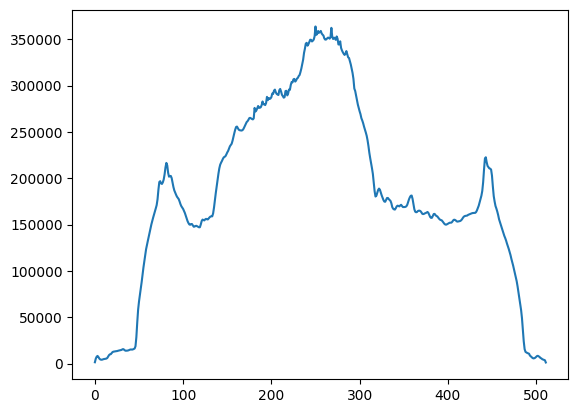

In [7]:
projections = [CT_data[:, j] for j in range(CT_data.shape[1])]
plt.plot(projections[179]) # 180번째 열의 프로젝션

In [8]:
print(len(projections)) # theta = 1 ~ 180, 총 180개 프로젝션
print(len(projections[0])) # 각 프로젝션의 길이, 즉 sinogram의 행의 길이

180
512


In [9]:
projections[:2]

[array([  1337.3376203 ,   2999.80624961,   3894.02907581,   4277.60908898,
          4661.74547128,   5059.57299741,   6522.15961319,   7036.287748  ,
          7642.65604184,   8240.0674216 ,   8185.020721  ,   7384.59797799,
          6491.20845066,   6099.63676693,   6370.18950283,   7160.54672272,
          8042.14611636,   9665.93185306,  10669.0697602 ,  10968.66644344,
         11240.32575277,  11814.23900682,  12535.34445016,  14301.98439704,
         19319.0555028 ,  28723.98705598,  40916.10929886,  51840.96670886,
         59779.3886844 ,  66234.00682084,  72355.97749964,  78365.09575346,
         84406.68640842,  90060.04135629,  94890.64254756,  98932.36494792,
        102548.27944785, 106129.22507626, 110180.29905052, 113830.9907294 ,
        117230.33777137, 120965.85043894, 124372.2710827 , 127483.39975542,
        130205.40023688, 132831.96100404, 135473.06999912, 137810.72232539,
        140678.15124782, 144065.92531781, 147396.69871948, 151430.00533602,
        1554

# Back projection
#### 1) Implement the back-projection algorithm and show the reconstruction result.

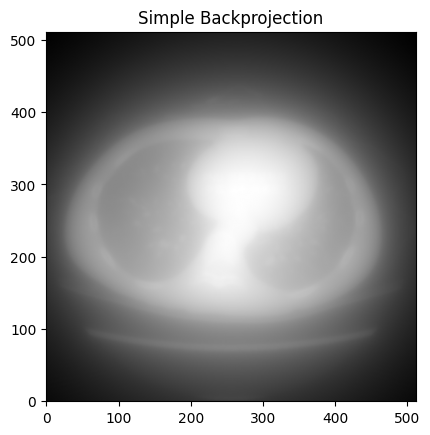

In [10]:
theta = np.deg2rad(np.arange(1,181))
r = CT_data.shape[0] # 512
img = np.zeros((r,r))
grid = np.linspace(-r/2, r/2, r) * 2.0  # mm 단위

x, y = np.meshgrid(grid, grid)

for i, th in enumerate(theta):
    p =  x * np.cos(th) + y * np.sin(th)
    idx =  (p/2 + r/2).astype(np.int32).clip(0, r-1)
    img += CT_data[idx, i][:, :]
    
plt.imshow(img, cmap='gray', origin='lower')
plt.title('Simple Backprojection')
plt.show()

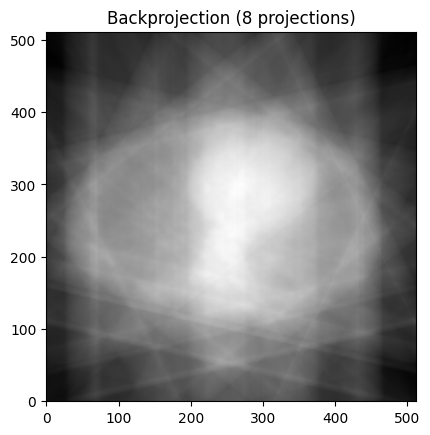

In [12]:
idxs = np.linspace(0, len(theta)-1, 8, dtype=int)

img_tmp = np.zeros((r, r))
for i in idxs:
    th = theta[i]
    p   = x*np.cos(th) + y*np.sin(th)
    idx = (p/2 + r/2).astype(int).clip(0, r-1)
    img_tmp += CT_data[idx, i]

plt.imshow(img_tmp, cmap='gray', origin='lower')
plt.title('Backprojection (8 projections)')
plt.show()

# Filtered Back-projection

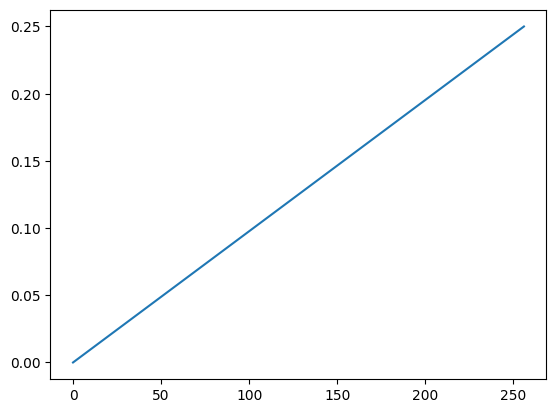

In [12]:
nf = 512
freq = np.fft.rfftfreq(nf, d=2.0)

ramp = np.abs(freq)

plt.plot(freq)

# 필터 적용에 따른 결과 그래프로 확인

In [13]:
N = 512
nf = 1024
d = 2.0

In [14]:
x_ex = np.arange(N) * d
CT_data_tmp = CT_data.T
proj_grap = CT_data[:, 90]
signal = proj_grap

In [30]:
P_graph = np.fft.rfft(signal, nf)
f = np.fft.rfftfreq(nf, d=d)
ramp_g = np.abs(f)

In [31]:
P_filt = P_graph * ramp_g
filtered_signal = np.fft.irfft(P_filt, nf)[:N]

full_freqs = np.fft.fftfreq(nf, d=d)
ramp_v = np.abs(full_freqs)
ramp_v_shifted = np.fft.fftshift(ramp_v)
full_freqs_shifted = np.fft.fftshift(full_freqs)

spectrum = np.abs(P_graph)
spectrum_filt = np.abs(P_filt)

sns.set_theme(style="whitegrid")

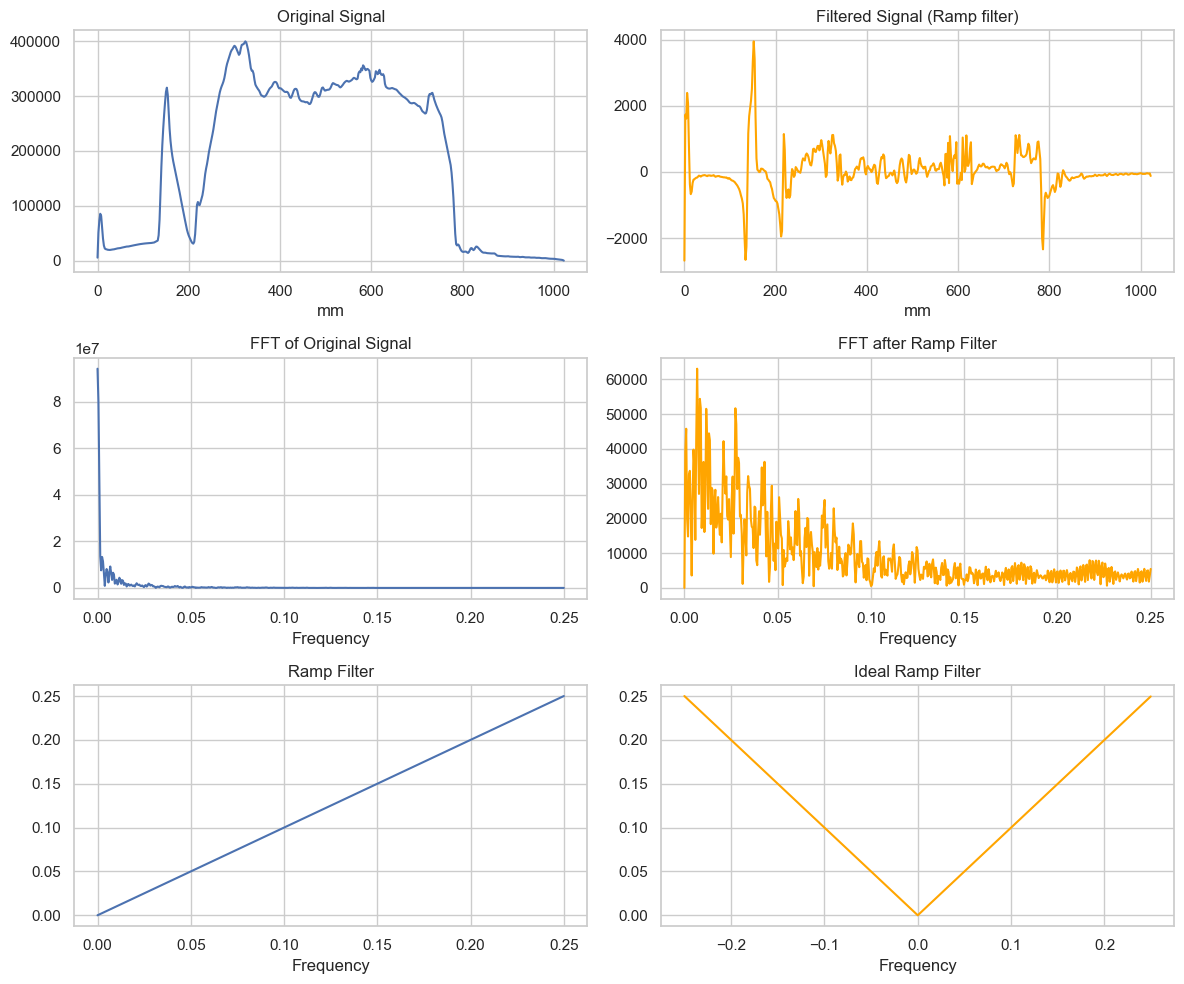

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# 원본
axs[0, 0].plot(x_ex, signal)
axs[0, 0].set_title("Original Signal")
axs[0, 0].set_xlabel("mm")

# 필터 적용
axs[0, 1].plot(x_ex, filtered_signal, color="orange")
axs[0, 1].set_title("Filtered Signal (Ramp filter)")
axs[0, 1].set_xlabel("mm")

# 주파수 원본
axs[1, 0].plot(f, spectrum)
axs[1, 0].set_title("FFT of Original Signal")
axs[1, 0].set_xlabel("Frequency")

# 주파수 필터 적용
axs[1, 1].plot(f, spectrum_filt, color="orange")
axs[1, 1].set_title("FFT after Ramp Filter")
axs[1, 1].set_xlabel("Frequency")

# Ramp filter
axs[2, 0].plot(f, ramp_g)
axs[2, 0].set_title("Ramp Filter")
axs[2, 0].set_xlabel("Frequency")

# Ramp(이론)
axs[2, 1].plot(full_freqs_shifted, ramp_v_shifted, color="orange")
axs[2, 1].set_title("Ideal Ramp Filter")
axs[2, 1].set_xlabel("Frequency")

plt.tight_layout()

In [13]:
CT_filtered = np.zeros_like(CT_data)
for i in range(180):
    proj = CT_data[:, i]
    P = np.fft.rfft(proj, nf)
    P *= ramp
    CT_filtered[:, i] = np.fft.irfft(P, nf)[:r]

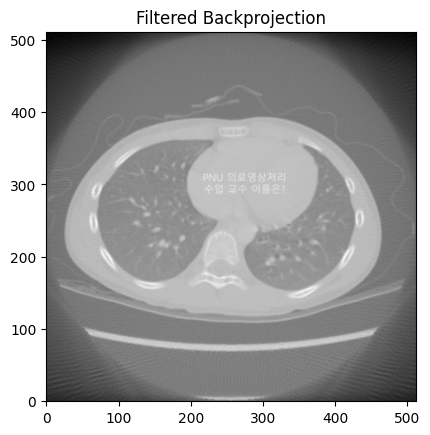

In [14]:
img_filtered = np.zeros((r, r))

for i, th in enumerate(theta):
    p = x * np.cos(th) + y * np.sin(th)
    idx   = (p/2 + r/2).astype(np.int32).clip(0, r-1)
    img_filtered += CT_filtered[idx, i]

plt.imshow(img_filtered, cmap='gray', origin='lower')
plt.title('Filtered Backprojection')
plt.show()

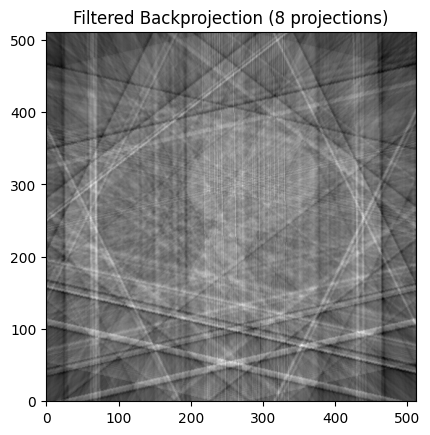

In [15]:
img_filtered_n = np.zeros((r, r))
idx_n = np.linspace(0, len(theta)-1, 8, dtype=int)

for i in idx_n:
    th = theta[i]
    p = x * np.cos(th) + y * np.sin(th)
    idx_n  = (p/2 + r/2).astype(int).clip(0, r-1)
    img_filtered_n += CT_filtered[idx_n, i]

plt.imshow(img_filtered_n, cmap='gray', origin='lower')
plt.title('Filtered Backprojection (8 projections)')
plt.show()

# Noise 추가

In [16]:
def add_gaussian_noise(data, sigma=0.01):
    gnoise = sigma * np.std(data) * np.random.randn(*data.shape)
    return data + gnoise

levels = [1.0, 2.0, 10.0, 20.0]
noisy_CT_data = {
    f"g_{s}": add_gaussian_noise(CT_data, sigma=s/100)
    for s in levels
}

In [17]:
noisy_CT_data

{'g_1.0': array([[1711.95592408,  -98.03999798, 1253.20841018, ..., 1695.52784936,
         4062.78654765, 2755.24553401],
        [3240.33243336, 2896.30274372, 4059.01524851, ..., 6574.71013889,
         4972.88127321, 5937.81561818],
        [2655.00691426, 4334.66259814, 5065.68455793, ..., 6483.48943118,
         6703.68663467, 7608.20714308],
        ...,
        [6791.61869862, 4215.22240371, 3878.1745027 , ..., 4832.62413862,
         4584.43596213, 5866.16242372],
        [3260.92661293, 1052.23605195,  537.00327999, ..., 7905.728493  ,
         5183.23062882, 5265.53659967],
        [ 844.15760933, -987.3172141 ,  347.44270819, ..., 3551.29744082,
         1379.20144322, 3459.91841342]]),
 'g_2.0': array([[  721.8370254 ,  5304.80453751,  1994.52856878, ...,
          3441.48835476,  1977.29816316,  1535.29962991],
        [ 4424.73010819,  3289.66009283,   619.8472432 , ...,
          4265.13250828,  5667.2452261 ,  6291.31024619],
        [ 1427.4985057 ,  6543.67569958,  3

In [18]:
def noisy_filtered_backprojection(data, theta, ramp, x, y, nf):
    r = data.shape[0]
    img = np.zeros((r, r))
    for i, th in enumerate(theta):
        proj = data[:, i]
        P = np.fft.rfft(proj, nf)
        P *= ramp
        proj_filt = np.fft.irfft(P, nf)[:r]
        idx = (x * np.cos(th) + y * np.sin(th))/2 + r/2
        idx = np.floor(idx).astype(int).clip(0, r-1)
        img += proj_filt[idx]
    return img

results = {}
for name, noisy_data in noisy_CT_data.items():
    tmp = noisy_filtered_backprojection(
        noisy_data,
        theta, ramp, x, y, nf
    )
    results[name] = tmp

In [19]:
results

{'g_1.0': array([[-48064.40956464, -46456.8126265 , -48186.80256153, ...,
         -50681.67520557, -52428.29907147, -51923.68077191],
        [-46326.35975516, -45993.46891075, -45866.32619388, ...,
         -46236.34253993, -51111.1009263 , -47816.07983114],
        [-46932.74421   , -46272.10969883, -44896.34041524, ...,
         -47495.11747556, -51943.35455875, -45628.38062267],
        ...,
        [-64141.19787133, -64002.90003288, -63180.91998032, ...,
         -60576.44899428, -58827.62443053, -61899.38895971],
        [-66046.16075101, -62514.26356129, -61862.70076549, ...,
         -57844.26313055, -61004.73564871, -60089.50450504],
        [-62923.37568898, -64539.74175629, -61880.91286909, ...,
         -60559.12676726, -60063.85864149, -61238.51519031]]),
 'g_2.0': array([[-48002.85138788, -52427.37567157, -58822.2821602 , ...,
         -49677.33616268, -59135.47270624, -54418.40883343],
        [-46383.71797403, -33256.14424971, -47949.58922451, ...,
         -57346.8080

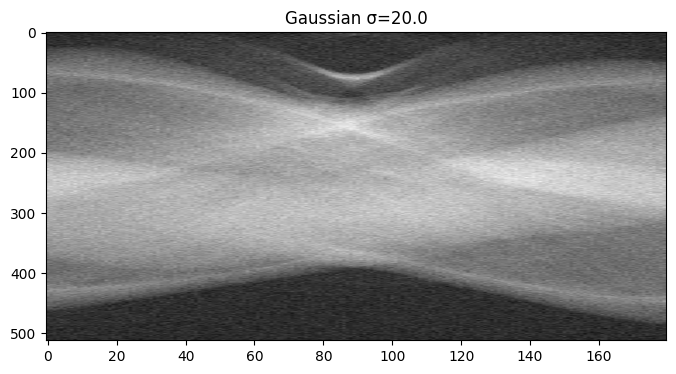

In [20]:
plt.figure(figsize=(8,4))
plt.imshow(noisy_CT_data['g_20.0'], cmap='gray', aspect='auto')
plt.title('Gaussian σ=20.0')
plt.show()

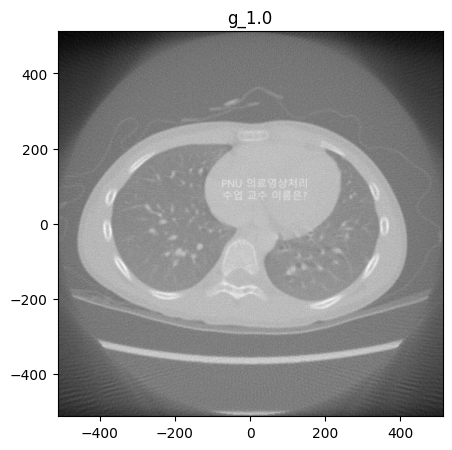

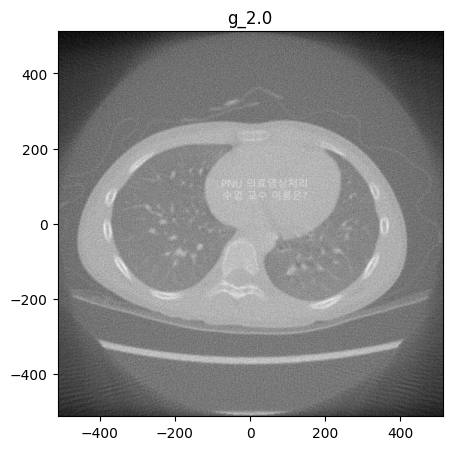

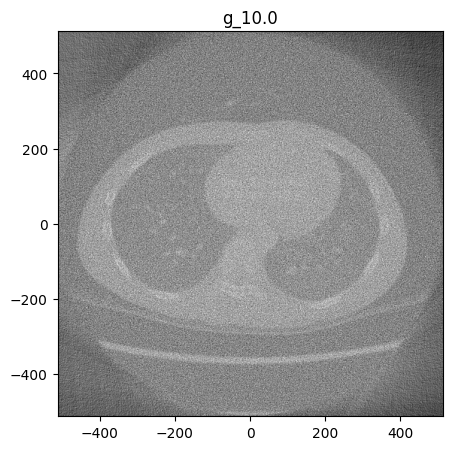

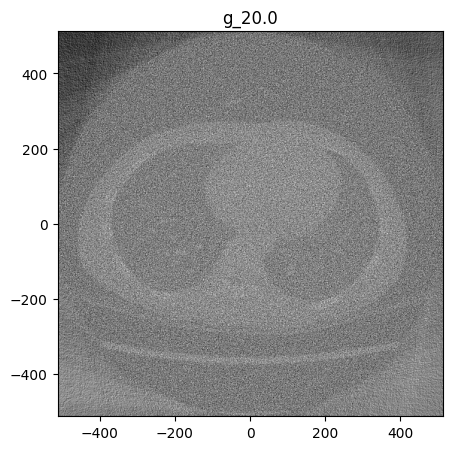

In [21]:
for name, data in results.items():
    plt.figure(figsize=(5,5))
    plt.imshow(data, cmap='gray', origin='lower', extent=[-r*1, r*1, -r*1, r*1])
    plt.title(f'{name}')
    plt.show()

# 노이즈 별 다양한 필터 적용

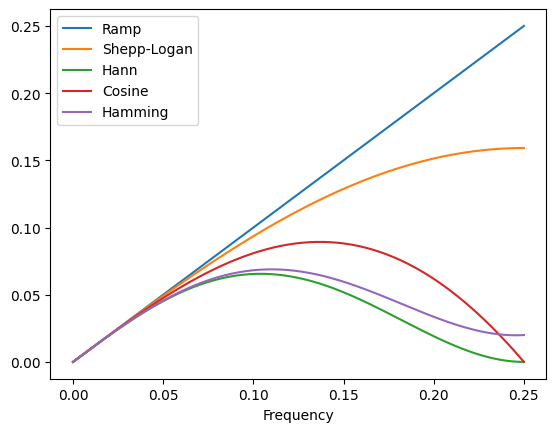

In [22]:
shepp_logan = ramp * np.sinc(freq/(2*freq.max()))
hann = ramp * 0.5*(1+ np.cos(np.pi*freq/freq.max()))
cosine = ramp * np.cos(np.pi * freq/(2*freq.max()))
hamming = ramp * (0.54 + 0.46 * np.cos(np.pi * freq/freq.max()))

plt.plot(freq, ramp, label='Ramp')
plt.plot(freq, shepp_logan, label='Shepp-Logan')
plt.plot(freq, hann, label='Hann')
plt.plot(freq, cosine, label='Cosine')
plt.plot(freq, hamming, label='Hamming')
plt.xlabel('Frequency')
plt.legend()
plt.show()

### 노이즈가 섞인 데이터에 서로 다른 필터를 적용한 결과

In [23]:
def various_filters(data, theta, filter, x, y, nf):
    r = data.shape[0]
    img = np.zeros((r, r))
    for i, th in enumerate(theta):
        proj = data[:, i]
        P = np.fft.rfft(proj, nf)
        P *= filter
        proj_filt = np.fft.irfft(P, nf)[:r]
        idx = (x * np.cos(th) + y * np.sin(th))/2 + r/2
        idx = np.floor(idx).astype(int).clip(0, r-1)
        img += proj_filt[idx]
    return img

In [24]:
results_2 = {}
for name, noisy_data in noisy_CT_data.items():
    tmp = various_filters(
        noisy_data,
        theta, cosine, x, y, nf
    )
    results_2[name] = tmp

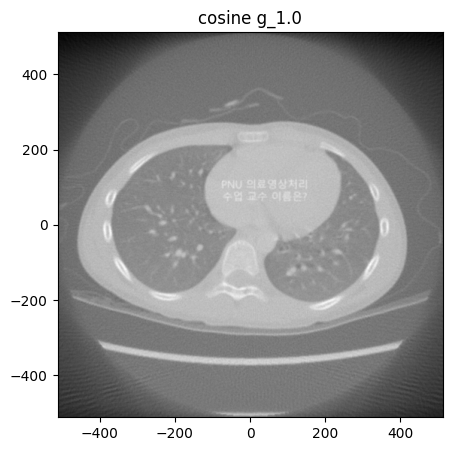

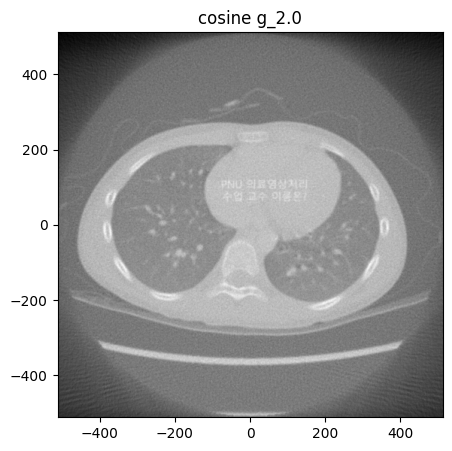

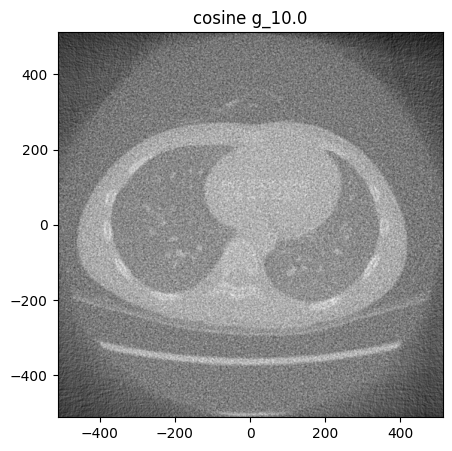

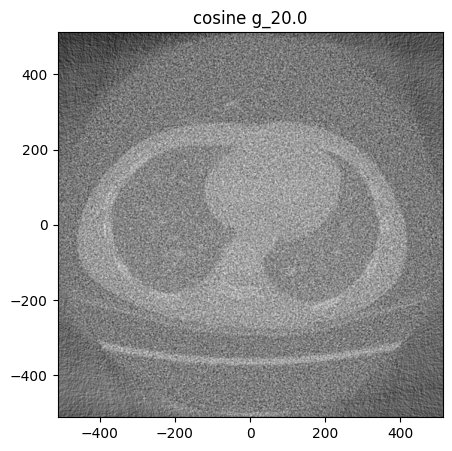

In [ ]:
for name, data in results_2.items():
    plt.figure(figsize=(5,5))
    plt.imshow(data, cmap='gray', origin='lower', extent=[-r*1, r*1, -r*1, r*1])
    plt.title(f'cosine {name}')
    file = f'cosine{name}.png'
    plt.savefig(file)
    plt.show()

In [ ]:
sino = noisy_CT_data['g_2.0']
r, n_angles = sino.shape
theta = np.linspace(0., 180., n_angles, endpoint=False)
x = np.zeros((r, r))

/home/jeonk636/.local/lib/python3.10/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


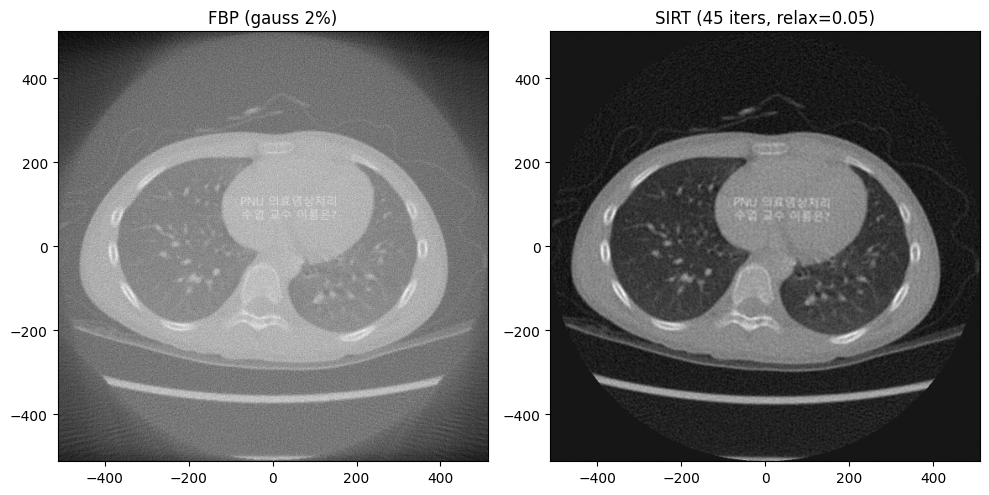

In [ ]:
n_iter = 45
relax  = 0.05

for it in range(n_iter):
    p_hat = radon(x, theta, circle=True)
    e = sino - p_hat
    bp = iradon(e, theta, filter_name='hamming', circle=True, output_size=r)
    x += relax * bp
    x = denoise_tv_chambolle(x, weight=0.003)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(results['g_2.0'], cmap='gray', origin='lower', extent=[-r, r, -r, r])
ax1.set_title('FBP (gauss 2%)');

ax2.imshow(x, cmap='gray', origin='upper', extent=[-r, r, -r, r])
ax2.set_title(f'SIRT ({n_iter} iters, relax={relax})');

plt.tight_layout()
plt.show()